# Checking for bad maps

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append("..")
import os
from utils.model3 import Net_mask
from utils.data import Data
from utils.loss_experiment import Loss
from scripts.parameters import get_parameters
import torch
import numpy as np
import matplotlib.pyplot as plt

In [31]:
tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps, tensor_Q_m, sigma2_eps, tau2 = get_parameters()
data_generator = Data(tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps)
#loss = Loss()

In [32]:
tensor_raw = data_generator.get_tensor_data(1, [1, 2.5, 1, 2.5, 1], [0, 4,5,6, 9])

tensor([[ 0.0000, -0.0000, -0.0000, -0.0000, -1.3919, -0.0000,  0.9751, -1.5983,
         -2.2073,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  1.0000,  1.0000,  0.0000]])


(-0.5, 9.5, -3.0, 3.0)

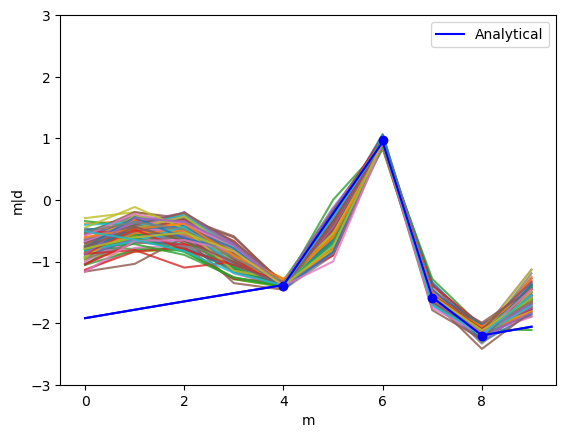

In [33]:
# bad maps and avg bnn
# Getting tensor
#tensor_raw = data_generator.get_tensor_data(1, [1, 0, 0.5, 0], [2, 4, 5, 9]) # nr 1
#tensor_raw = data_generator.get_tensor_data(1, [0.5, -0.9, 0.6, 0], [3, 6, 7, 9]) # nr 2
#tensor_raw = data_generator.get_tensor_data(1, [0.7, 1.7, -1.2, -0.3], [1, 3, 6, 7]) # nr 3
#tensor_raw = data_generator.get_tensor_data(1, [0.9, -0.8, 0.3, 0.4], [1, 3, 7, 8]) # nr 4
#tensor_raw = data_generator.get_tensor_data(1, num=4)
tensor_raw = data_generator.get_tensor_data(1)
print(tensor_raw)
n_param = 10
input_tensor = tensor_raw[0]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
points = tensor_raw[0][location_raw]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)

# Plotting model estimates
model = Net_mask()

names = []
sum_tensor_map = torch.zeros(n_param)

n_runs = 100
plt.plot(range(10), post_mean, 'b')
sum_tensor_bnn = torch.zeros(n_param)
for f in range(n_runs): 
    name = '../saved_models/combined2/pos/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    sum_tensor_bnn += out
    plt.plot(range(10), out, alpha=0.8)#, 'o')
#plt.plot(range(10), sum_tensor_bnn/10, 'r')

#for f in range(10): 
#for f in [0]: 
#    name = '../saved_models/combined/map/' + str(f) + '/' + 'model_weights.pth'
#    model.load_state_dict(torch.load(name))
#    model.eval()
#    out_raw = model(tensor_raw)
#    out = out_raw[0].detach()
#    sum_tensor_map += out
#    #plt.plot(range(10), out, alpha=0.5)#, 'o')
#    plt.plot(range(10), out, 'g')#, 'o')
#    names.append(str(f))

plt.plot(range(10), post_mean, 'b')
plt.plot(location, points, 'bo')
#plt.title("Bad MAP estimate vs bagged BNN estimate")
plt.xlabel("m")
plt.ylabel("m|d")
plt.legend(['Analytical'])#, 'Bagged BNN', 'MAP'])
#plt.legend(names)
plt.axis([-0.5, 9.5, -3, 3])
#plt.savefig('../figures/bnn4.pdf')


In [34]:
#tensor_raw = data_generator.get_tensor_data(1, [0, 2.5, -1, -0.5], [3, 5, 6, 7])
#tensor_raw = data_generator.get_tensor_data(1, [-0.6, 1.4, 0.5, 1.2], [1, 3, 6, 9]) # nr 2, bad=6, points=4
#tensor_raw = data_generator.get_tensor_data(1, [1, 1, -0.3, -0.8], [0, 1, 3, 5]) # nr 1, bad=1, points=4
tensor_raw = data_generator.get_tensor_data(1, [0.4, -0.7, -2, 0], [1, 2, 5, 8]) # nr 4, bad=0, points=4
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
tau2 = 1000 # 1/tau2 is the noise added to the diagonal
tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
loss = Loss(tensor_Q_m_modified, sigma2_eps, 1/(0.5**2*100_000))

losses = torch.zeros(10)
for f in range(10): 
    name = '../saved_models/combined/map/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    print(f, loss.loss(tensor_raw, out_raw, model)[0])
    #out = out_raw[0].detach()
    #sum_tensor_map += out
    #plt.plot(range(10), out, alpha=1)#, 'o')
    #names.append(str(f))


0 tensor(3.6360, grad_fn=<AddBackward0>)
1 tensor(7.9732, grad_fn=<AddBackward0>)
2 tensor(4.8000, grad_fn=<AddBackward0>)
3 tensor(7.6499, grad_fn=<AddBackward0>)
4 tensor(6.6094, grad_fn=<AddBackward0>)
5 tensor(3.5927, grad_fn=<AddBackward0>)
6 tensor(4.2663, grad_fn=<AddBackward0>)
7 tensor(4.2545, grad_fn=<AddBackward0>)
8 tensor(4.9138, grad_fn=<AddBackward0>)
9 tensor(3.9237, grad_fn=<AddBackward0>)


In [35]:
tensor_raw = data_generator.get_tensor_data(1, [0, 2.5, -1, -0.5], [3, 5, 6, 7])

(-0.5, 9.5, -3.0, 3.0)

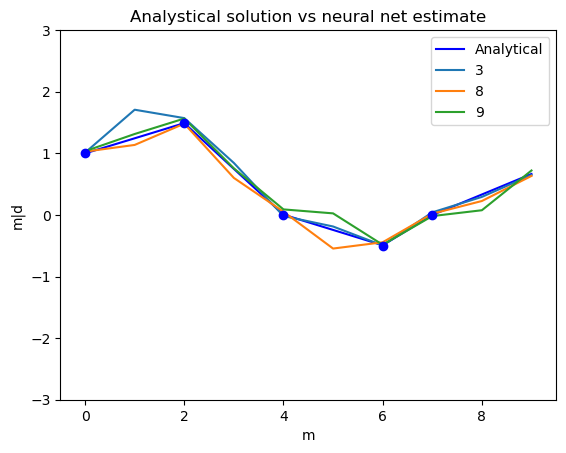

In [36]:
# Getting tensor
tensor_raw = data_generator.get_tensor_data(1, [1, 1.5, 0, -0.5, 0], [0, 2, 4, 6, 7])
n_param = 10
input_tensor = tensor_raw[0]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
points = tensor_raw[0][location_raw]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)

# Plotting model estimates
outer_dir = 'combined/map'
rootdir = "../saved_models/" + str(outer_dir)
model = Net_mask()
names = []
for subdir, dirs, files in os.walk(rootdir):
    folders = dirs
    count = len(folders)
    break

plt.plot(range(10), post_mean, 'b')
names.append('Analytical')
sum_tensor_maps = torch.zeros(n_param)
#for f in folders: 
for f in ['3', '8', '9']: 
    name = '../saved_models/' + str(outer_dir) + '/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    sum_tensor_maps += out
    plt.plot(range(10), out, alpha=1)#, 'o')
    names.append(str(f))


#plt.plot(range(10), sum_tensor_maps/count, 'r')
plt.title("Analystical solution vs neural net estimate")
plt.xlabel("m")
plt.ylabel("m|d")
plt.legend(names)
plt.plot(location, points, 'bo')
plt.axis([-0.5, 9.5, -3, 3])

tensor([[ 1.0000,  0.0000,  1.5000,  0.0000,  0.0000,  0.0000, -0.5000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  0.0000]])


(-0.5, 9.5, -3.0, 3.0)

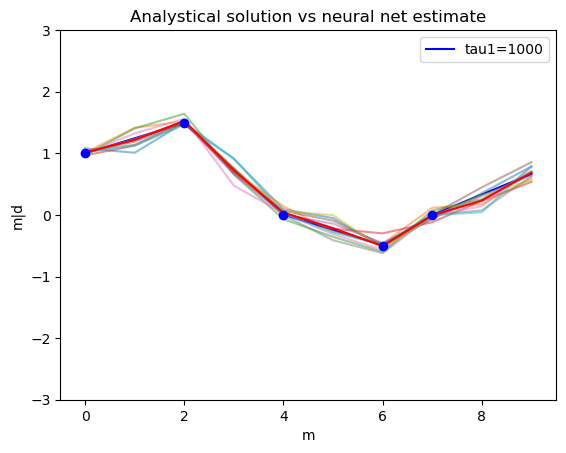

In [37]:
# Getting tensor
tensor_raw = data_generator.get_tensor_data(1, [1, 1.5, 0, -0.5, 0], [0, 2, 4, 6, 7])
#tensor_raw = data_generator.get_tensor_data(1)
print(tensor_raw)
n_param = 10
input_tensor = tensor_raw[0]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
points = tensor_raw[0][location_raw]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)

# Plotting model estimates
outer_dir = 'combined/pos'
rootdir = "../saved_models/" + str(outer_dir)
model = Net_mask()
names = []
for subdir, dirs, files in os.walk(rootdir):
    folders = dirs
    count = len(folders)
    break

plt.plot(range(10), post_mean, 'b')
sum_tensor_maps = torch.zeros(n_param)
for f in folders: 
    name = '../saved_models/' + str(outer_dir) + '/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    sum_tensor_maps += out
    plt.plot(range(10), out, alpha=0.5)#, 'o')

plt.plot(range(10), sum_tensor_maps/count, 'r')
plt.title("Analystical solution vs neural net estimate")
plt.xlabel("m")
plt.ylabel("m|d")
plt.legend(['tau1=1000'])
plt.plot(location, points, 'bo')
plt.axis([-0.5, 9.5, -3, 3])

(-0.5, 9.5, -3.0, 3.0)

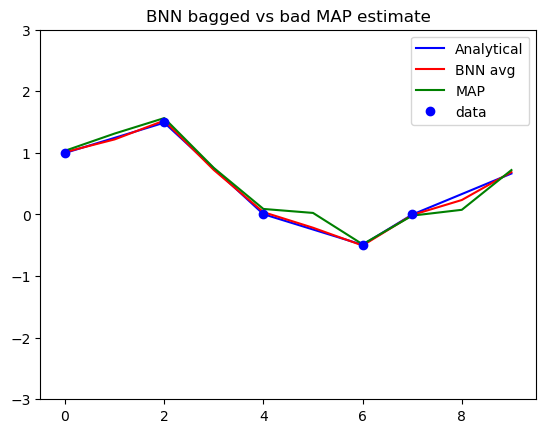

In [38]:
plt.plot(range(10), post_mean, 'b')
plt.plot(range(10), sum_tensor_maps/count, 'r')

tensor_raw = data_generator.get_tensor_data(1, [1, 1.5, 0, -0.5, 0], [0, 2, 4, 6, 7])
#for f in ['3', '8', '9']: 
for f in ['9']: 
    name = '../saved_models/combined/' + 'map' + '/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    #sum_tensor_maps += out
    #plt.plot(range(10), out, alpha=1)#, 'o')
    plt.plot(range(10), out, 'g')#, 'o')
    #names.append(str(f))

plt.plot(location, points, 'bo')
plt.legend(['Analytical', 'BNN avg', 'MAP', 'data'])
plt.title('BNN bagged vs bad MAP estimate')
plt.axis([-0.5, 9.5, -3, 3])

In [39]:

# Getting tensor
n_param = 10
input_tensor = tensor_raw[0]
d = input_tensor[:10]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)
post_mean2, _ = data_generator2.get_tensor_posterior(input_tensor)

# Plotting model estimates
outer_dir = 'map_vs_bnn_bnns'
rootdir = "../saved_models/" + str(outer_dir)
model = Net_mask()
names = []
for subdir, dirs, files in os.walk(rootdir):
    folders = dirs
    count = len(folders)
    break

plt.plot(range(10), post_mean, 'g')
plt.plot(range(10), post_mean2, 'r')
sum_tensor_bnns = torch.zeros(n_param)
for f in folders: 
    name = '../saved_models/' + str(outer_dir) + '/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    print(list(model.parameters())[0][0][:10])
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    #print(out.size())
    #print(out)
    sum_tensor_bnns += out
    #plt.plot(range(10), post_mean)
    #plt.plot(range(10), out)
    #out = out + torch.randn(10)*0.01

    #if f == '0':
    #    plt.plot(range(10), out, 'g')#, 'o')
    #    plt.plot(location, out[location_raw], 'go')
    #else:
    #    plt.plot(range(10), out, '--', alpha=0.5)#, 'o')
    plt.plot(range(10), out, alpha=0.5)#, 'o')

    #plt.plot(location, out[location_raw], 'o')
    #names.append(str(f))
    #print(out)
plt.plot(range(10), sum_tensor_bnns/count, 'b')
plt.title("Analystical solution vs neural net estimate")
plt.xlabel("m")
plt.ylabel("m|d")
#plt.legend(['tau1=1000', 'tau1=1', 'default', 'map', 'positive', 'negative', 'average'])
plt.legend(['tau1=1000', 'tau1=1'])
plt.plot(location, post_mean[location_raw], 'go')
plt.plot(location, post_mean2[location_raw], 'ro')
plt.plot(location, (sum_tensor_bnns/count)[location_raw], 'bo')
#names.append("Analytical tau2=1000")
#names.append("Analytical tau=1")
#names.append("MAP mean")
#plt.legend(names)
#plt.legend()

NameError: name 'data_generator2' is not defined

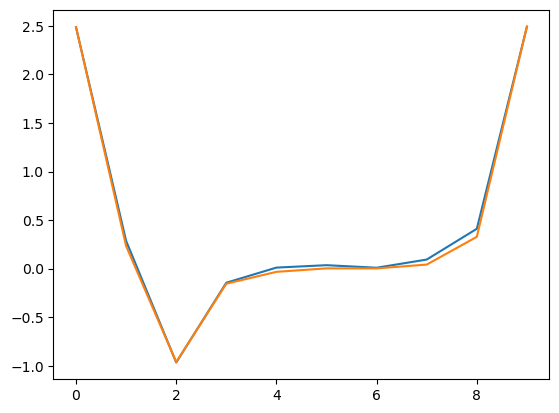

In [ ]:
plt.plot(range(10), sum_tensor_bnns/count)
plt.plot(range(10), sum_tensor_maps/count)

tensor([ 0.0132, -0.0778, -0.0930, -0.3629,  0.7952, -0.1987, -0.0024, -0.0216,
        -0.0363, -0.0286], grad_fn=<SliceBackward0>)
tensor([ 0.0091, -0.0662, -0.1286,  0.0800, -0.0594,  0.1027,  0.0093, -0.0008,
        -0.0976,  0.1246], grad_fn=<SliceBackward0>)
tensor([ 0.0171,  0.0196,  0.0512,  0.0513,  0.7758,  0.0618, -0.0263, -0.7201,
        -0.0718, -0.0423], grad_fn=<SliceBackward0>)
tensor([-2.7522e-01,  8.7599e-03,  8.7671e-03, -2.7909e-03, -2.9168e-03,
         8.1086e-04,  1.1081e-02, -3.4106e-02, -2.1471e-01,  1.0012e+00],
       grad_fn=<SliceBackward0>)
tensor([ 0.0459,  0.0456,  0.0215,  0.0088, -0.0403, -0.1765,  1.1043, -0.2062,
        -0.0539, -0.0038], grad_fn=<SliceBackward0>)
tensor([-0.1491,  0.5222, -0.2686,  0.0514,  0.0879,  0.5065,  0.0586,  0.0725,
         0.5652,  0.0009], grad_fn=<SliceBackward0>)
tensor([ 0.0915,  0.2535, -0.0588, -0.3043, -0.1375,  0.1744,  0.2633, -0.1170,
        -0.1010, -0.3141], grad_fn=<SliceBackward0>)
tensor([ 0.0065,  0.24

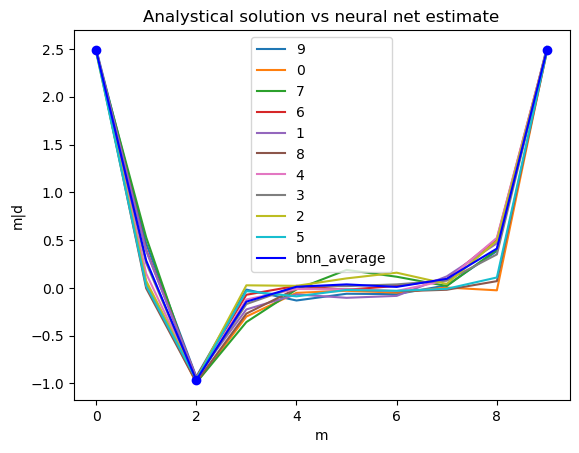

In [ ]:
# Getting tensor
n_param = 10
input_tensor = tensor_raw[0]
d = input_tensor[:10]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)
post_mean2, _ = data_generator2.get_tensor_posterior(input_tensor)

# Plotting model estimates
outer_dir = 'map_vs_bnn_maps'
rootdir = "../saved_models/" + str(outer_dir)
model = Net_mask()
names = []
for subdir, dirs, files in os.walk(rootdir):
    folders = dirs
    count = len(folders)
    break

#plt.plot(range(10), post_mean, 'g')
#plt.plot(range(10), post_mean2, 'r')
sum_tensor_maps = torch.zeros(n_param)
for f in folders: 
    name = '../saved_models/' + str(outer_dir) + '/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    print(list(model.parameters())[0][0][:10])
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    #print(out.size())
    #print(out)
    sum_tensor_maps += out
    #plt.plot(range(10), post_mean)
    #plt.plot(range(10), out)
    #out = out + torch.randn(10)*0.01

    #if f == '0':
    #    plt.plot(range(10), out, 'g')#, 'o')
    #    plt.plot(location, out[location_raw], 'go')
    #else:
    #    plt.plot(range(10), out, '--', alpha=0.5)#, 'o')
    plt.plot(range(10), out, alpha=1)#, 'o')

    #plt.plot(location, out[location_raw], 'o')
    names.append(str(f))
    #print(out)
#plt.plot(range(10), sum_tensor_bnns/count, 'b')
plt.plot(range(10), sum_tensor_bnns/count, 'b')
plt.title("Analystical solution vs neural net estimate")
plt.xlabel("m")
plt.ylabel("m|d")
#plt.legend(['tau1=1000', 'tau1=1', 'default', 'map', 'positive', 'negative', 'average'])
#plt.legend(['tau1=1000', 'tau1=1'])
#plt.plot(location, post_mean[location_raw], 'go')
#plt.plot(location, post_mean2[location_raw], 'ro')
names.append('bnn_average')
plt.plot(location, (sum_tensor_bnns/count)[location_raw], 'bo')
plt.legend(names)
#names.append("Analytical tau2=1000")
#names.append("Analytical tau=1")
#names.append("MAP mean")
#plt.legend(names)
#plt.legend()

tensor([ 0.0091, -0.0662, -0.1286,  0.0800, -0.0594,  0.1027,  0.0093, -0.0008,
        -0.0976,  0.1246], grad_fn=<SliceBackward0>)
tensor([ 0.0171,  0.0196,  0.0512,  0.0513,  0.7758,  0.0618, -0.0263, -0.7201,
        -0.0718, -0.0423], grad_fn=<SliceBackward0>)
tensor([-0.0160,  0.0025,  0.0136,  0.2469, -1.0619,  0.1848,  0.0192, -0.0117,
         0.0164, -0.0098], grad_fn=<SliceBackward0>)


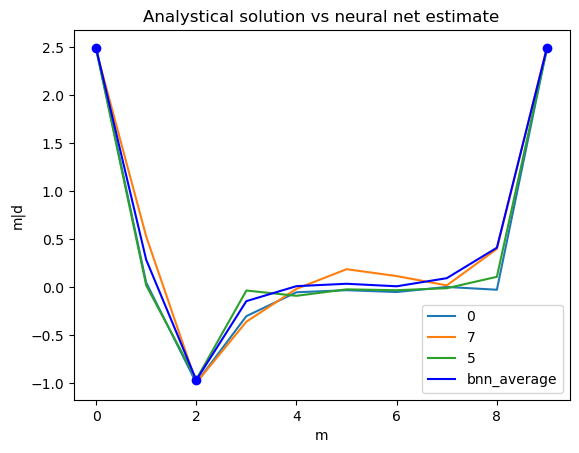

In [ ]:
# Getting tensor
n_param = 10
input_tensor = tensor_raw[0]
d = input_tensor[:10]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)
post_mean2, _ = data_generator2.get_tensor_posterior(input_tensor)

# Plotting model estimates
outer_dir = 'map_vs_bnn_maps'
rootdir = "../saved_models/" + str(outer_dir)
model = Net_mask()
names = []
for subdir, dirs, files in os.walk(rootdir):
    folders = dirs
    count = len(folders)
    break

#plt.plot(range(10), post_mean, 'g')
#plt.plot(range(10), post_mean2, 'r')
sum_tensor_maps = torch.zeros(n_param)
for f in folders: 
    if f == '0' or f == '7' or f == '5':
        name = '../saved_models/' + str(outer_dir) + '/' + str(f) + '/' + 'model_weights.pth'
        model.load_state_dict(torch.load(name))
        model.eval()
        print(list(model.parameters())[0][0][:10])
        out_raw = model(tensor_raw)
        out = out_raw[0].detach()
        #print(out.size())
        #print(out)
        sum_tensor_maps += out
        #plt.plot(range(10), post_mean)
        #plt.plot(range(10), out)
        #out = out + torch.randn(10)*0.01

        #if f == '0':
        #    plt.plot(range(10), out, 'g')#, 'o')
        #    plt.plot(location, out[location_raw], 'go')
        #else:
        #    plt.plot(range(10), out, '--', alpha=0.5)#, 'o')
        plt.plot(range(10), out, alpha=1)#, 'o')

        #plt.plot(location, out[location_raw], 'o')
        names.append(str(f))
    else:
        continue
    #print(out)
#plt.plot(range(10), sum_tensor_bnns/count, 'b')
plt.plot(range(10), sum_tensor_bnns/count, 'b')
plt.title("Analystical solution vs neural net estimate")
plt.xlabel("m")
plt.ylabel("m|d")
#plt.legend(['tau1=1000', 'tau1=1', 'default', 'map', 'positive', 'negative', 'average'])
#plt.legend(['tau1=1000', 'tau1=1'])
#plt.plot(location, post_mean[location_raw], 'go')
#plt.plot(location, post_mean2[location_raw], 'ro')
names.append('bnn_average')
plt.plot(location, (sum_tensor_bnns/count)[location_raw], 'bo')
plt.legend(names)
#names.append("Analytical tau2=1000")
#names.append("Analytical tau=1")
#names.append("MAP mean")
#plt.legend(names)
#plt.legend()